# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [ ]:
!ls


In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%matplotlib inline

from sklearn.metrics import mean_squared_error as MSE
from math import sqrt
#Time series analysis tools.
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pylab import rcParams
plt.style.use('fivethirtyeight')

from fbprophet import Prophet as proph

In [115]:
df_zillow = pd.read_csv('zillow_data.csv')

In [116]:
print(df_zillow.SizeRank.describe(),'\n')
#Calculate the 20% cutoff value.
sr_20 = df_zillow.SizeRank.quantile(q=0.20)

count    14723.000000
mean      7362.000000
std       4250.308342
min          1.000000
25%       3681.500000
50%       7362.000000
75%      11042.500000
max      14723.000000
Name: SizeRank, dtype: float64 



In [117]:
df_zillow.shape

(14723, 272)

In [122]:
zc_top20= df_zillow[df_zillow['SizeRank']<sr_20]

In [119]:
zc_top20.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06   ...     2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0   ...     1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0   ...      308000   310000   312500   
2         3  210400.0  212200.0  212200.0   ...      321000   320600   320200   
3         4  498100.0  500900.0  503100.0   ...     1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0   ...      119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [120]:
zc_top20.shape

(2945, 272)

In [121]:
zc_top20['yr_avg']=zc_top20.iloc[:,-12:].mean(skipna=True, axis=1)

In [73]:
zc_top20['ROI']= (zc_top20['2018-04']/zc_top20['1996-04'])-1

In [74]:
zc_top20['std']=zc_top20.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)
zc_top20['mean']=zc_top20.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)
zc_top20['CV']=zc_top20['std']/zc_top20['mean']

In [75]:
zc_top20.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06    ...     2017-12  2018-01  \
0         1  334200.0  335400.0  336500.0    ...     1018700  1024400   
1         2  235700.0  236900.0  236700.0    ...      316600   318100   
2         3  210400.0  212200.0  212200.0    ...      321200   321200   
3         4  498100.0  500900.0  503100.0    ...     1299000  1302700   
4         5   77300.0   77300.0   77300.0    ...      120300   120300   

   2018-02  2018-03  2018-04        yr_avg       ROI            std  \
0  1030700  1033800  1030600  1.014358e+06  2.083782  190821.103965   
1   319600   321100   321800  3.141667e+05  0.365295   33537.101427   
2   323000   326900   329900  3.221750e+05  0.567966   37730.794353   
3  1306400  1308500  1307000  1.295967e+06  1.623971  231225.944628   
4   120500   121000   121500  1.200167e+05  0.571798   18167.079218   

            mean        CV  
0  743978.867925  0.256487  
1  219655.849057  0.152680  
2  262110.566038  0.143950  
3  974139.245283  0.237364  
4  101875.471698  0.178326  

[5 rows x 277 columns]

In [76]:
def melt_data1(df):   
    mdf = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], 
               value_vars = df.loc[:, "1996-04":"2018-04"], value_name = 'Value', var_name = 'Date')
    mdf = mdf.dropna(subset=['Value', 'Metro'])
    return mdf

In [77]:
zc_df = melt_data1(zc_top20)

In [78]:
print(zc_df.shape)
zc_df.head()

(770865, 8)


RegionName      City State              Metro CountyName  SizeRank  \
0       60657   Chicago    IL            Chicago       Cook         1   
1       75070  McKinney    TX  Dallas-Fort Worth     Collin         2   
2       77494      Katy    TX            Houston     Harris         3   
3       60614   Chicago    IL            Chicago       Cook         4   
4       79936   El Paso    TX            El Paso    El Paso         5   

      Date     Value  
0  1996-04  334200.0  
1  1996-04  235700.0  
2  1996-04  210400.0  
3  1996-04  498100.0  
4  1996-04   77300.0

In [79]:
ts_60657 = zc_df.loc[zc_df['RegionName']==60657]
ts_60657.head()

RegionName     City State    Metro CountyName  SizeRank     Date  \
0           60657  Chicago    IL  Chicago       Cook         1  1996-04   
2945        60657  Chicago    IL  Chicago       Cook         1  1996-05   
5890        60657  Chicago    IL  Chicago       Cook         1  1996-06   
8835        60657  Chicago    IL  Chicago       Cook         1  1996-07   
11780       60657  Chicago    IL  Chicago       Cook         1  1996-08   

          Value  
0      334200.0  
2945   335400.0  
5890   336500.0  
8835   337600.0  
11780  338500.0

In [80]:
ts_60657_df = ts_60657[['Date', 'Value']]


In [81]:
ts_60657_df.head()

Date     Value
0      1996-04  334200.0
2945   1996-05  335400.0
5890   1996-06  336500.0
8835   1996-07  337600.0
11780  1996-08  338500.0

In [82]:
zc_df.RegionName.unique()

array([60657, 75070, 77494, ..., 89030, 10456, 95351])

In [83]:
dfs_ts = []
for zc in zc_df.RegionName.unique():
    #Create separate dataframes for each zipcode with a monthly frequency.
    df = zc_df[zc_df['RegionName']==zc]
    dfs_ts.append(df)

In [84]:
dfs_ts

[        RegionName     City State    Metro CountyName  SizeRank     Date  \
 0            60657  Chicago    IL  Chicago       Cook         1  1996-04   
 2945         60657  Chicago    IL  Chicago       Cook         1  1996-05   
 5890         60657  Chicago    IL  Chicago       Cook         1  1996-06   
 8835         60657  Chicago    IL  Chicago       Cook         1  1996-07   
 11780        60657  Chicago    IL  Chicago       Cook         1  1996-08   
 14725        60657  Chicago    IL  Chicago       Cook         1  1996-09   
 17670        60657  Chicago    IL  Chicago       Cook         1  1996-10   
 20615        60657  Chicago    IL  Chicago       Cook         1  1996-11   
 23560        60657  Chicago    IL  Chicago       Cook         1  1996-12   
 26505        60657  Chicago    IL  Chicago       Cook         1  1997-01   
 29450        60657  Chicago    IL  Chicago       Cook         1  1997-02   
 32395        60657  Chicago    IL  Chicago       Cook         1  1997-03   

In [85]:
for zc in zc_df.RegionName.unique():
    #Create separate dataframes for each zipcode with a monthly frequency.
    df = zc_df[zc_df['RegionName']==zc]

In [86]:
def prophet(df):
    df = df.rename(columns={'Date': 'ds',
                        'Value': 'y'})
    Model = proph(interval_width=0.95)
    Model.fit(df)
    future_dates = Model.make_future_dataframe(periods=12, freq='MS')
    forecast = Model.predict(future_dates)
    output = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    return output.tail(12)

def prophet_graph(df):
    df = df.rename(columns={'Date': 'ds',
                        'Value': 'y'})
    Model = proph(interval_width=0.95)
    Model.fit(df)
    future_dates = Model.make_future_dataframe(periods=12, freq='MS')
    forecast = Model.predict(future_dates)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    Model.plot(forecast, uncertainty=True)
    return plt.show()

In [87]:
ts_60657_prophet = prophet(ts_60657)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [88]:
ts_60657_prophet

ds          yhat    yhat_lower    yhat_upper
265 2018-05-01  1.041982e+06  1.030807e+06  1.053046e+06
266 2018-06-01  1.045505e+06  1.034584e+06  1.056071e+06
267 2018-07-01  1.048695e+06  1.037474e+06  1.060287e+06
268 2018-08-01  1.051971e+06  1.040140e+06  1.063430e+06
269 2018-09-01  1.055357e+06  1.042910e+06  1.067982e+06
270 2018-10-01  1.058903e+06  1.042519e+06  1.071968e+06
271 2018-11-01  1.062107e+06  1.045324e+06  1.077837e+06
272 2018-12-01  1.065378e+06  1.045790e+06  1.082771e+06
273 2019-01-01  1.068616e+06  1.046552e+06  1.091411e+06
274 2019-02-01  1.071788e+06  1.045096e+06  1.099085e+06
275 2019-03-01  1.075724e+06  1.045166e+06  1.106285e+06
276 2019-04-01  1.078485e+06  1.043341e+06  1.115098e+06

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


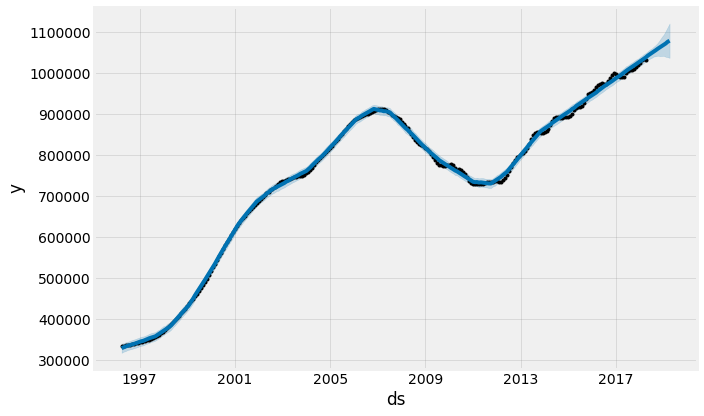

In [108]:
prophet_graph(ts_60657)

In [90]:
zipcodes = zc_df['RegionName'].unique()

predictions = []
for zipcode in zipcodes:
    prediction = prophet()
    predictions.append(prediction)

TypeError: prophet() missing 1 required positional argument: 'df'

In [ ]:
# zc_top20.iloc[:,-17:-5].mean()

# Step 2: Data Preprocessing

In [ ]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [92]:
cd home_value_prediction/

/Users/flatiron/Flatiron/9week/dsc-mod-4-project-seattle-ds-062419/home_value_prediction


In [98]:
prediction_df = pd.read_csv('home_value_prediction/prediction.csv')

In [101]:
prediction_df.sort_values(by='diff', ascending=False).head()

Unnamed: 0  current_price          ds         y_hat   y_hat_lower  \
56           56      1854300.0  2019-04-01  2.113064e+06  2.064652e+06   
74           74      1419100.0  2019-04-01  1.627992e+06  1.571867e+06   
30           30      1966900.0  2019-04-01  2.168947e+06  2.075317e+06   
131         131      1489900.0  2019-04-01  1.655067e+06  1.587448e+06   
66           66       930600.0  2019-04-01  1.076904e+06  1.044679e+06   

      y_hat_upper    zip           diff  
56   2.160554e+06   7030  258763.992588  
74   1.685322e+06  90034  208891.855820  
30   2.270130e+06  90046  202047.359744  
131  1.727028e+06  90066  165166.552627  
66   1.107075e+06  98052  146304.295695

In [103]:
best_zip5 = prediction_df.loc[(prediction_df['zip'] == 7030) | (prediction_df['zip'] == 90034) 
                             | (prediction_df['zip'] == 90046) | (prediction_df['zip'] == 90066)
                             | (prediction_df['zip'] == 98052)]
best_zip5

Unnamed: 0  current_price          ds         y_hat   y_hat_lower  \
30           30      1966900.0  2019-04-01  2.168947e+06  2.075317e+06   
56           56      1854300.0  2019-04-01  2.113064e+06  2.064652e+06   
66           66       930600.0  2019-04-01  1.076904e+06  1.044679e+06   
74           74      1419100.0  2019-04-01  1.627992e+06  1.571867e+06   
131         131      1489900.0  2019-04-01  1.655067e+06  1.587448e+06   

      y_hat_upper    zip           diff  
30   2.270130e+06  90046  202047.359744  
56   2.160554e+06   7030  258763.992588  
66   1.107075e+06  98052  146304.295695  
74   1.685322e+06  90034  208891.855820  
131  1.727028e+06  90066  165166.552627

In [125]:
best_zip = melt_data1(zc_top20)
best_zip.head()

RegionName      City State              Metro CountyName  SizeRank  \
0       60657   Chicago    IL            Chicago       Cook         1   
1       75070  McKinney    TX  Dallas-Fort Worth     Collin         2   
2       77494      Katy    TX            Houston     Harris         3   
3       60614   Chicago    IL            Chicago       Cook         4   
4       79936   El Paso    TX            El Paso    El Paso         5   

      Date     Value  
0  1996-04  334200.0  
1  1996-04  235700.0  
2  1996-04  210400.0  
3  1996-04  498100.0  
4  1996-04   77300.0

In [131]:
ts_7030 = best_zip.loc[best_zip['RegionName'] == 7030]
ts_90034 = best_zip.loc[best_zip['RegionName'] == 90034]
ts_90046 = best_zip.loc[best_zip['RegionName'] == 90046]
ts_90066 = best_zip.loc[best_zip['RegionName'] == 90066]
ts_98052 = best_zip.loc[best_zip['RegionName'] == 98052]

In [132]:
ts_7030.head()

RegionName     City State     Metro CountyName  SizeRank     Date  \
57           7030  Hoboken    NJ  New York     Hudson        58  1996-04   
3002         7030  Hoboken    NJ  New York     Hudson        58  1996-05   
5947         7030  Hoboken    NJ  New York     Hudson        58  1996-06   
8892         7030  Hoboken    NJ  New York     Hudson        58  1996-07   
11837        7030  Hoboken    NJ  New York     Hudson        58  1996-08   

          Value  
57     301600.0  
3002   302700.0  
5947   303800.0  
8892   304800.0  
11837  305800.0

In [133]:
ts_7030 = ts_7030[['Date', 'Value']]  
ts_90034 = ts_90034[['Date', 'Value']]
ts_90046 = ts_90046[['Date', 'Value']]
ts_90066 = ts_90066[['Date', 'Value']]
ts_98052 = ts_98052[['Date', 'Value']]

In [134]:
ts_7030.head()

Date     Value
57     1996-04  301600.0
3002   1996-05  302700.0
5947   1996-06  303800.0
8892   1996-07  304800.0
11837  1996-08  305800.0

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


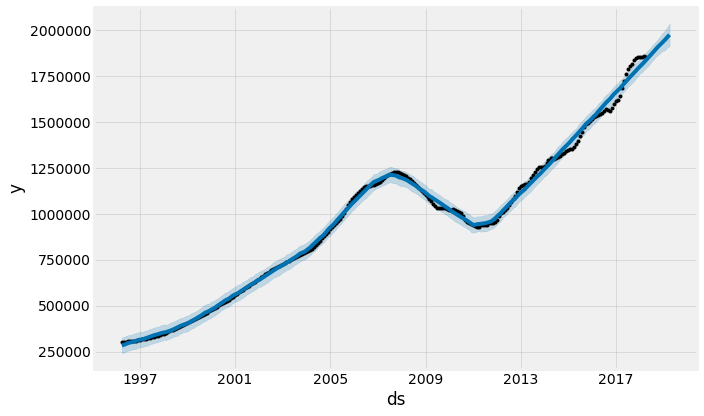

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


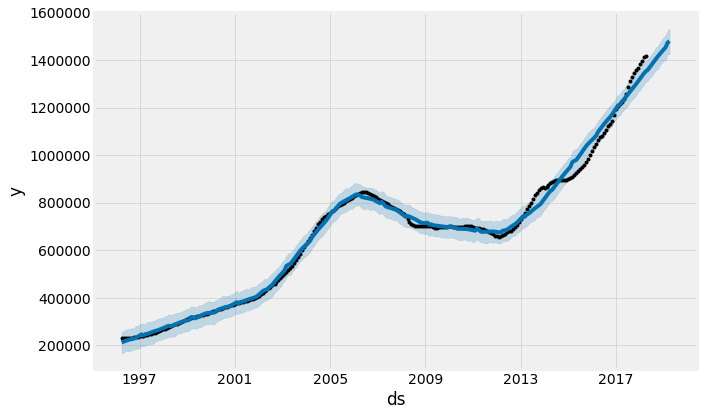

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


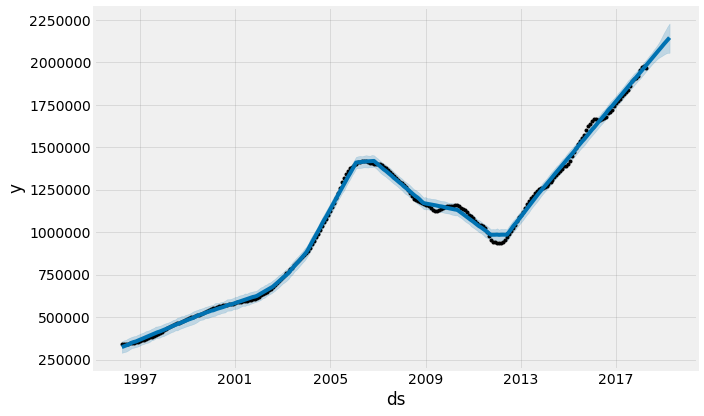

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


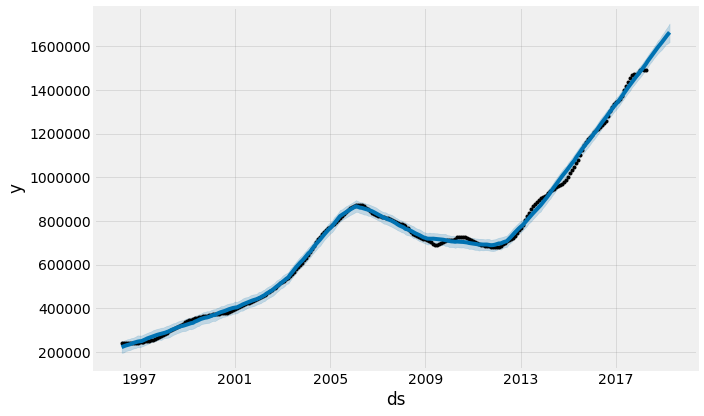

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


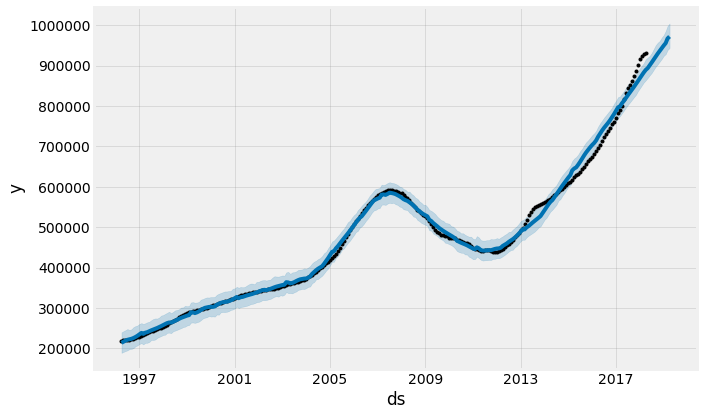

In [137]:
prophet_graph(ts_7030)
prophet_graph(ts_90034)
prophet_graph(ts_90046)
prophet_graph(ts_90066)
prophet_graph(ts_98052)


In [139]:
best_zip5 = best_zip.loc[(best_zip['RegionName'] == 7030) | (best_zip['RegionName'] == 90034) 
                             | (best_zip['RegionName'] == 90046) | (best_zip['RegionName'] == 90066)
                             | (best_zip['RegionName'] == 98052)]
best_zip5.head()

RegionName         City State                           Metro  \
30        90046  Los Angeles    CA  Los Angeles-Long Beach-Anaheim   
57         7030      Hoboken    NJ                        New York   
67        98052      Redmond    WA                         Seattle   
75        90034  Los Angeles    CA  Los Angeles-Long Beach-Anaheim   
133       90066  Los Angeles    CA  Los Angeles-Long Beach-Anaheim   

      CountyName  SizeRank     Date     Value  
30   Los Angeles        31  1996-04  340600.0  
57        Hudson        58  1996-04  301600.0  
67          King        68  1996-04  219700.0  
75   Los Angeles        76  1996-04  231300.0  
133  Los Angeles       134  1996-04  241100.0

In [140]:
dfs_t = best_zip5[['RegionName','Date','Value']]
dfs_t.head()

RegionName     Date     Value
30        90046  1996-04  340600.0
57         7030  1996-04  301600.0
67        98052  1996-04  219700.0
75        90034  1996-04  231300.0
133       90066  1996-04  241100.0

In [153]:
dfs_t.isna().sum()

RegionName    0
Value         0
dtype: int64

In [141]:
dfs_t.Date = pd.to_datetime(dfs_t.Date)
dfs_t = dfs_t.set_index('Date')
dfs_t.index = pd.DatetimeIndex(dfs_t.index)

In [143]:
dfs_ts = []
for zc in dfs_t.RegionName.unique():
    #Create separate dataframes for each zipcode with a monthly frequency.
    df = dfs_t[dfs_t['RegionName']==zc]
    dfs_ts.append(df)
print('\nZipcode 90046 time series:')
dfs_ts[0].head()


Zipcode 90046 time series:


RegionName     Value
Date                            
1996-04-01       90046  340600.0
1996-05-01       90046  341700.0
1996-06-01       90046  343000.0
1996-07-01       90046  344400.0
1996-08-01       90046  346100.0

In [151]:
dfs_ts[1].head()

RegionName     Value
Date                            
1996-04-01        7030  301600.0
1996-05-01        7030  302700.0
1996-06-01        7030  303800.0
1996-07-01        7030  304800.0
1996-08-01        7030  305800.0

In [175]:
dfs_ts[1].columns

AttributeError: 'list' object has no attribute 'columns'

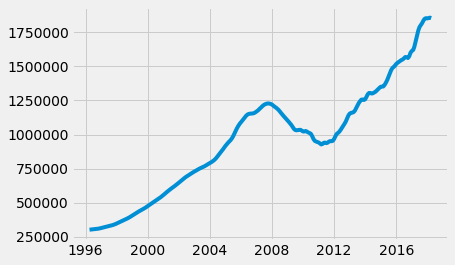

In [178]:
plt.plot(dfs_ts[1].Value);

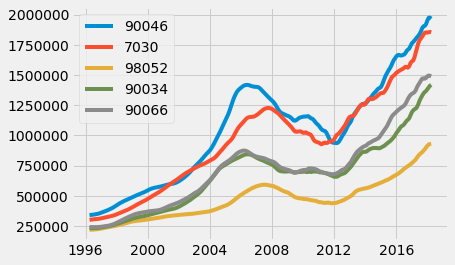

In [180]:
for i in range(5):
    plt.plot(dfs_ts[i].Value, label=dfs_ts[i].RegionName[0])
    plt.legend()

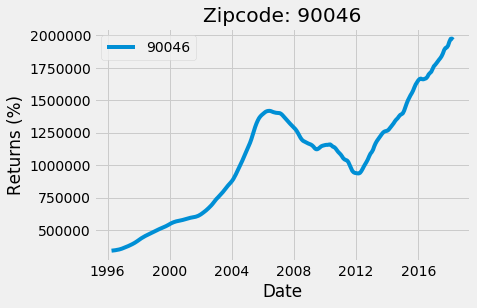

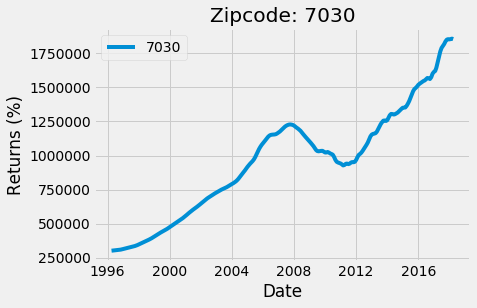

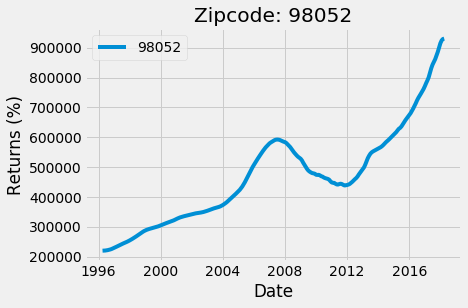

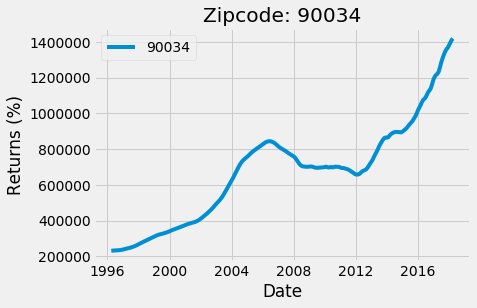

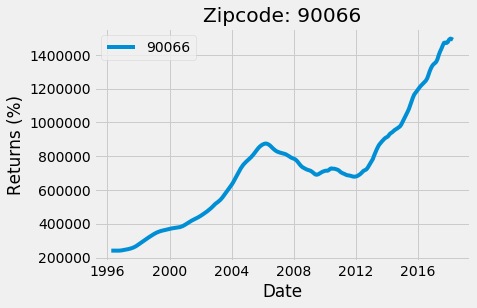

In [182]:
for i in range(len(dfs_ts)):
    plt.plot(dfs_ts[i].Value, label=dfs_ts[i].RegionName[0])
    plt.title(f'Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.xlabel('Date')
    plt.ylabel('Returns (%)')
    plt.legend(loc='best')
    plt.show()

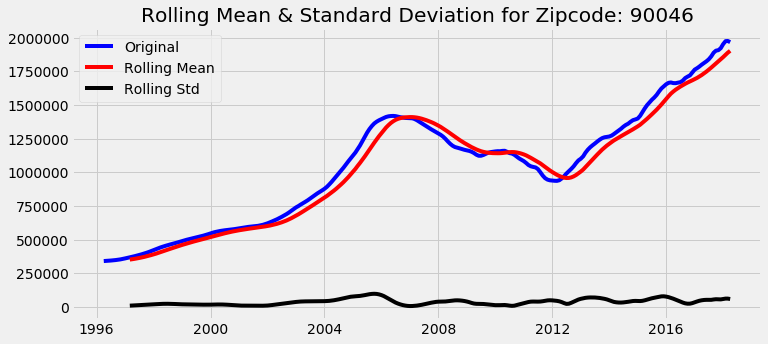

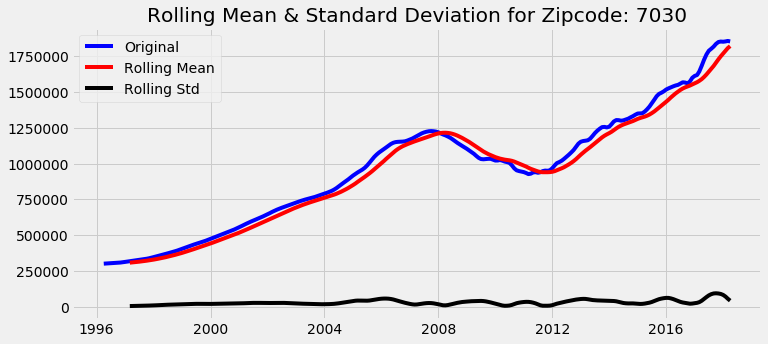

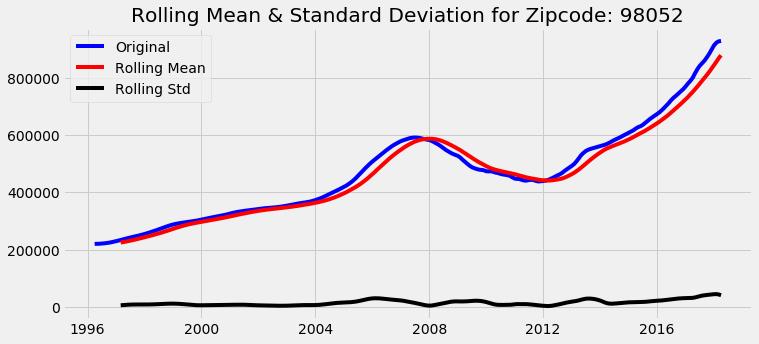

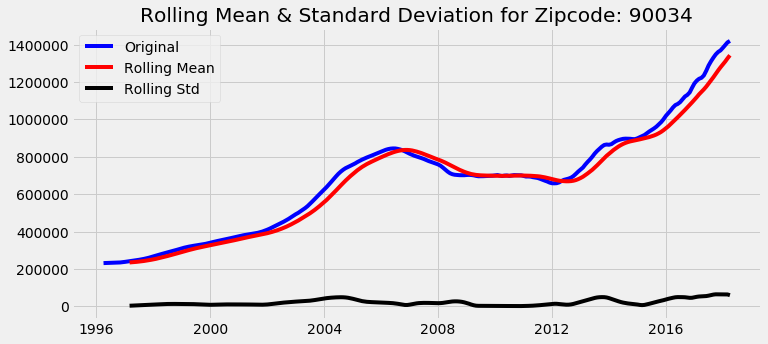

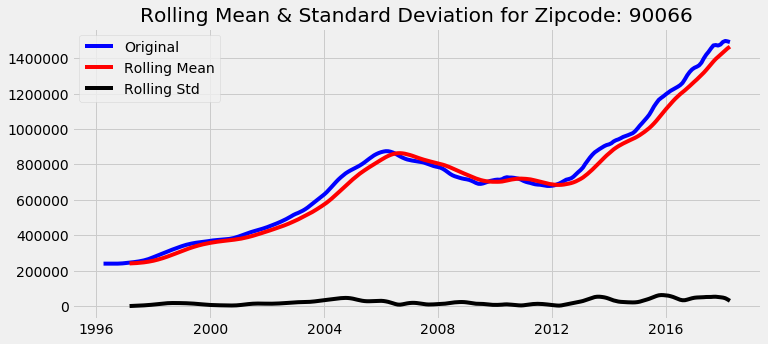

In [183]:
for i in range(len(dfs_ts)):
    rolmean = dfs_ts[i].Value.rolling(window = 12, center = False).mean()
    rolstd = dfs_ts[i].Value.rolling(window = 12, center = False).std()
    fig = plt.figure(figsize=(11,5))
    orig = plt.plot(dfs_ts[i].Value, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.show()

In [184]:
for i in range(5):
    results = adfuller(dfs_ts[i].Value.dropna())
    print(f'ADFuller test p-value for zipcode: {dfs_ts[i].RegionName[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 90046
p-value: 0.7621567166816606
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 7030
p-value: 0.8913263672522288
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 98052
p-value: 0.9064442718592205
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 90034
p-value: 0.9497148224721286
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 90066
p-value: 0.8634462873263347
Fail to reject the null hypothesis. Data is not stationary.



In [185]:
for zc in range(len(dfs_ts)):
    dfs_ts[zc]['ret']=np.nan*len(dfs_ts[zc])
    for i in range(len(dfs_ts[zc])-1):
        dfs_ts[zc]['ret'][i+1]= (dfs_ts[zc].Value.iloc[i+1] / dfs_ts[zc].Value.iloc[i]) - 1

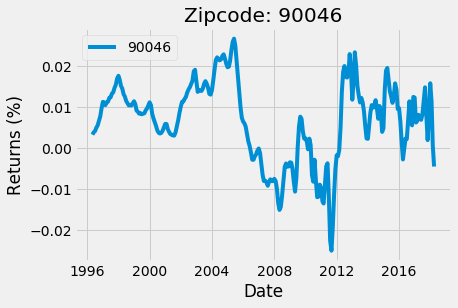

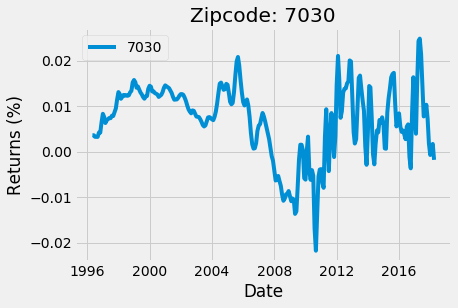

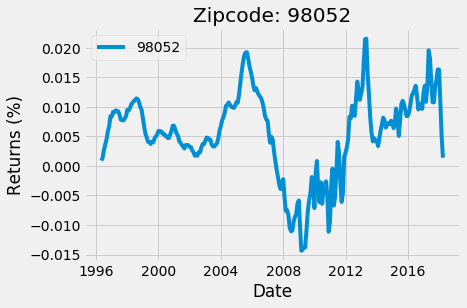

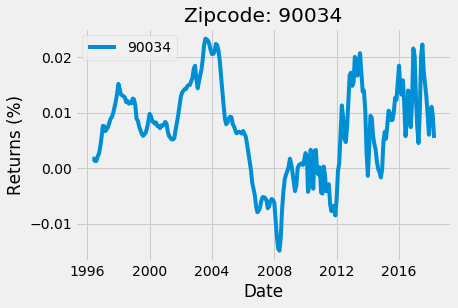

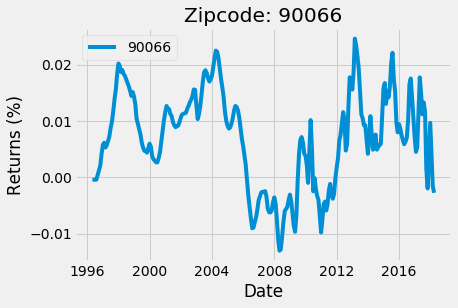

In [188]:
for i in range(len(dfs_ts)):
    plt.plot(dfs_ts[i].ret, label=dfs_ts[i].RegionName[0])
#     dfs_ts[i].ret.plot(figsize=(11,5), color = 'b')
    plt.title(f'Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.xlabel('Date')
    plt.ylabel('Returns (%)')
    plt.legend(loc='best')
    plt.show()

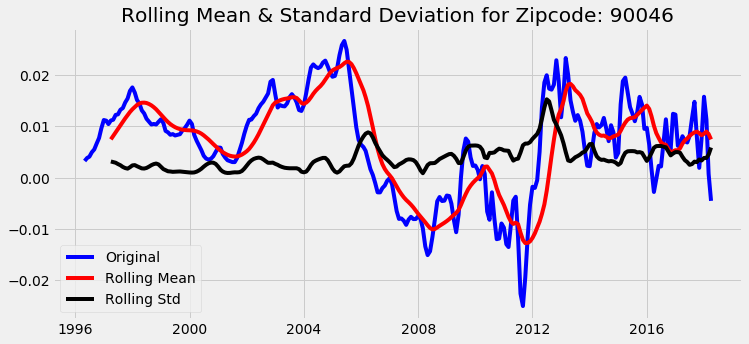

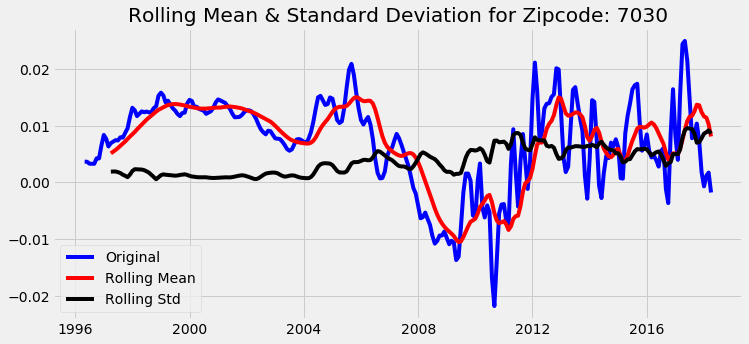

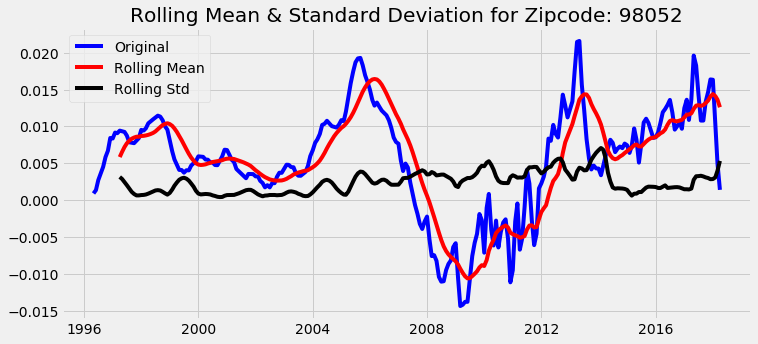

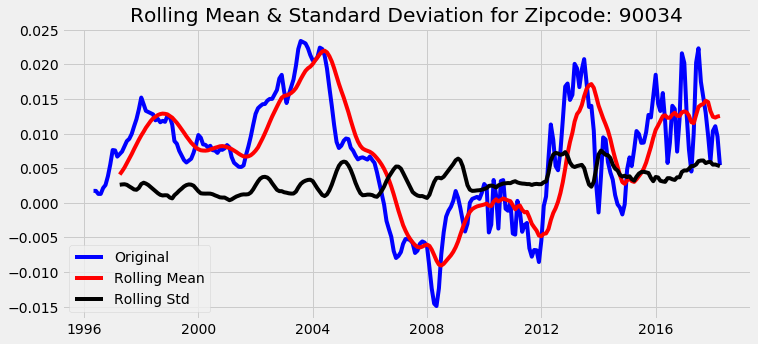

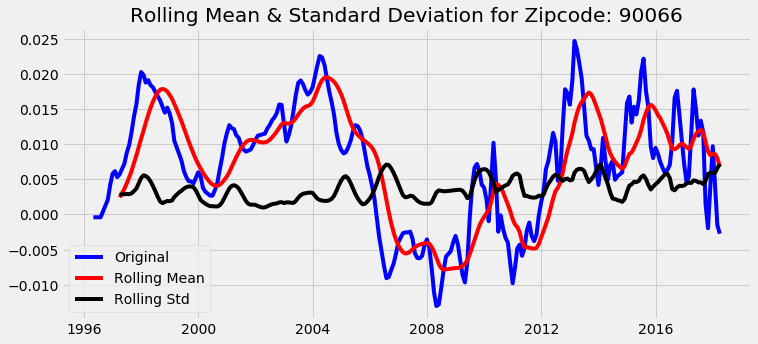

In [189]:
for i in range(len(dfs_ts)):
    rolmean = dfs_ts[i].ret.rolling(window = 12, center = False).mean()
    rolstd = dfs_ts[i].ret.rolling(window = 12, center = False).std()
    fig = plt.figure(figsize=(11,5))
    orig = plt.plot(dfs_ts[i].ret, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.show()

In [190]:
for i in range(5):
    results = adfuller(dfs_ts[i].ret.diff().dropna())
    print(f'ADFuller test p-value for zipcode: {dfs_ts[i].RegionName[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 90046
p-value: 9.995588187546272e-07
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 7030
p-value: 7.326952672530468e-05
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 98052
p-value: 0.021903638416093225
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 90034
p-value: 0.0008678380595283124
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 90066
p-value: 4.458858135962074e-06
Reject the null hypothesis. Data is stationary.



In [201]:
df_zillow.sort_values(by='SizeRank', ascending=False)

RegionID  RegionName                 City State  \
14722     95851       89155             Mesquite    NV   
14721     93733       81225  Mount Crested Butte    CO   
14720     75672       40404                Berea    KY   
14719     59107        3293            Woodstock    NH   
14718     58333        1338             Ashfield    MA   
14717     62697       12720               Bethel    NY   
14716     99032       97028         Rhododendron    OR   
14715     62556       12429               Esopus    NY   
14714     94711       84781          Pine Valley    UT   
14713     59187        3765            Haverhill    NH   
14712     96822       92341    Green Valley Lake    CA   
14711     95893       89413            Glenbrook    NV   
14710     59210        3812             Bartlett    NH   
14709     96805       92322            Crestline    CA   
14708     99401       97733             Crescent    OR   
14707     69681       28039         East Spencer    NC   
14706     59046        3215    Waterville Valley    NH   
14705     79929       49768             Paradise    MI   
14704     70763       29915             Bluffton    SC   
14703     94323       83821               Coolin    ID   
14702     62599       12480            Shandaken    NY   
14701     58327        1270              Windsor    MA   
14700     79881       49710              Barbeau    MI   
14699     93436       80510           Allenspark    CO   
14698     66509       20618             Bushwood    MD   
14697     66516       20625          Cobb Island    MD   
14696     93425       80481                 Ward    CO   
14695     91948       77457            Matagorda    TX   
14694     99114       97149             Neskowin    OR   
14693     62433       12156             Schodack    NY   
...         ...         ...                  ...   ...   
29        66126       20002           Washington    DC   
28        71067       30349            Riverdale    GA   
27        97771       94565            Pittsburg    CA   
26        92515       78572              Mission    TX   
25        93123       79912              El Paso    TX   
24        69816       28269            Charlotte    NC   
23        92045       77584             Pearland    TX   
22        92036       77573          League City    TX   
21        61703       10128             New York    NY   
20        61625       10011             New York    NY   
19        84620       60618              Chicago    IL   
18        92593       78660         Pflugerville    TX   
17        74242       37211            Nashville    TN   
16        84646       60647              Chicago    IL   
15        96107       90250            Hawthorne    CA   
14        74101       37013            Nashville    TN   
13        62045       11235             New York    NY   
12        62087       11375             New York    NY   
11        71831       32162         The Villages    FL   
10        62037       11226             New York    NY   
9         97564       94109        San Francisco    CA   
8         91940       77449                 Katy    TX   
7         84640       60640              Chicago    IL   
6         61807       10467             New York    NY   
5         91733       77084              Houston    TX   
4         93144       79936              El Paso    TX   
3         84616       60614              Chicago    IL   
2         91982       77494                 Katy    TX   
1         90668       75070             McKinney    TX   
0         84654       60657              Chicago    IL   

                                Metro            CountyName  SizeRank  \
14722                       Las Vegas                 Clark     14723   
14721                             NaN              Gunnison     14722   
14720                        Richmond               Madison     14721   
14719                       Claremont               Grafton     14720   
14718                 Greenfield Town        

In [196]:
df_zillow[df_zillow['City'] == 'Seattle'].sort_values(by='SizeRank')

RegionID  RegionName     City State    Metro CountyName  SizeRank  \
161      99563       98103  Seattle    WA  Seattle       King       162   
331      99575       98115  Seattle    WA  Seattle       King       332   
438      99581       98122  Seattle    WA  Seattle       King       439   
760      99583       98125  Seattle    WA  Seattle       King       761   
963      99569       98109  Seattle    WA  Seattle       King       964   
1061     99565       98105  Seattle    WA  Seattle       King      1062   
1082     99578       98118  Seattle    WA  Seattle       King      1083   
1484     99562       98102  Seattle    WA  Seattle       King      1485   
2157     99567       98107  Seattle    WA  Seattle       King      2158   
2179     99577       98117  Seattle    WA  Seattle       King      2180   
2537     99576       98116  Seattle    WA  Seattle       King      2538   
2598     99595       98144  Seattle    WA  Seattle       King      2599   
3017     99579       98119  Seattle    WA  Seattle       King      3018   
4026     99572       98112  Seattle    WA  Seattle       King      4027   
4070     99566       98106  Seattle    WA  Seattle       King      4071   
4232     99584       98126  Seattle    WA  Seattle       King      4233   
4608     99624       98199  Seattle    WA  Seattle       King      4609   
5436     99568       98108  Seattle    WA  Seattle       King      5437   
5992     99591       98136  Seattle    WA  Seattle       King      5993   

       1996-04   1996-05   1996-06   ...     2017-07  2017-08  2017-09  \
161   175700.0  175900.0  176300.0   ...      800000   808000   817100   
331   183400.0  183600.0  184000.0   ...      815800   819200   821900   
438   168900.0  169400.0  169900.0   ...      819000   825600   832100   
760   161200.0  161400.0  161700.0   ...      618500   625800   634100   
963   249000.0  251000.0  253000.0   ...     1103700  1115400  1129800   
1061  222700.0  223000.0  223400.0   ...      967900   978400   989800   
1082  132900.0  132900.0  132900.0   ...      538600   544200   549500   
1484  274000.0  276000.0  278100.0   ...     1183600  1202100  1221800   
2157  170100.0  170700.0  171400.0   ...      789600   794300   798200   
2179  166000.0  166500.0  167000.0   ...      767000   769000   771800   
2537  184000.0  184200.0  184400.0   ...      757800   761200   765700   
2598  143500.0  144000.0  144500.0   ...      677800   686000   695200   
3017  240100.0  241000.0  242000.0   ...     1000900  1010600  1018900   
4026  285200.0  285200.0  285300.0   ...     1253000  1258900  1266600   
4070  120100.0  120200.0  120300.0   ...      471800   481900   492100   
4232  143900.0  144100.0  144300.0   ...      576600   581100   586300   
4608  238100.0  237700.0  237400.0   ...      913700   922000   928500   
5436  128700.0  128700.0  128800.0   ...      521000   529200   537700   
5992  170600.0  171000.0  171600.0   ...      705600   712600   719700   

      2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
161    828500   842300   856700   869300   876500   880800   882800  
331    828400   837000   848300   860700   869400   877000   881900  
438    840100   849700   863000   877300   884000   885100   884700  
760    643000   652100   662400   672600   680200   686600   690200  
963   1145500  1163000  1181900  1198600  1210700  1221300  1227900  
1061  1001000  1012500  1024700  1038500  1050500  1062200  1069100  
1082   555700   561500   568700   577700   583500   585900   586000  
1484  1237500  1252400  1267800  1285100  1301200  1315900  1321600  
2157   804900   814400   827100   840200   847000   849600   850400  
2179   776000   782600   792700   804100   811800   816900   818500  
2537   771400   777600   786300   796300   804800   811600   814400  
2598   706200   718700   730500   741900   749100   751900   751500  
3017  1025000  1037900  1055500  1070100  1084700  1109800  1130000  
4026  1278000  1289000  1302500  1320600  13

In [200]:
df_zillow[df_zillow['RegionName'] == 98121]

Empty DataFrame
Columns: [RegionID, RegionName, City, State, Metro, CountyName, SizeRank, 1996-04, 1996-05, 1996-06, 1996-07, 1996-08, 1996-09, 1996-10, 1996-11, 1996-12, 1997-01, 1997-02, 1997-03, 1997-04, 1997-05, 1997-06, 1997-07, 1997-08, 1997-09, 1997-10, 1997-11, 1997-12, 1998-01, 1998-02, 1998-03, 1998-04, 1998-05, 1998-06, 1998-07, 1998-08, 1998-09, 1998-10, 1998-11, 1998-12, 1999-01, 1999-02, 1999-03, 1999-04, 1999-05, 1999-06, 1999-07, 1999-08, 1999-09, 1999-10, 1999-11, 1999-12, 2000-01, 2000-02, 2000-03, 2000-04, 2000-05, 2000-06, 2000-07, 2000-08, 2000-09, 2000-10, 2000-11, 2000-12, 2001-01, 2001-02, 2001-03, 2001-04, 2001-05, 2001-06, 2001-07, 2001-08, 2001-09, 2001-10, 2001-11, 2001-12, 2002-01, 2002-02, 2002-03, 2002-04, 2002-05, 2002-06, 2002-07, 2002-08, 2002-09, 2002-10, 2002-11, 2002-12, 2003-01, 2003-02, 2003-03, 2003-04, 2003-05, 2003-06, 2003-07, 2003-08, 2003-09, 2003-10, 2003-11, 2003-12, ...]
Index: []

[0 rows x 272 columns]

# Step 3: EDA and Visualization

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

# Step 4: Reshape from Wide to Long Format

In [ ]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

# Step 5: ARIMA Modeling

# Step 6: Interpreting Results